### PDPTW (2 índices) - modelo em Furtado et. al (2017), pg 3 (336)

In [1]:
# Importando as bibliotecas:

from docplex.mp.model import Model
from docplex.util.environment import get_environment
import pandas as pd
import numpy as np


In [2]:
# Rodando o programa com funções de ler instâncias e calcular distâncias entre nós:

%run utils

In [3]:
# obtendo instância e parâmetros iniciais:

instancia = 'AA10' # nome da instância

# dataframe com dados da instância e parâmetros específicos dela:

df, parameters = PDPTW_instancia('instances\PDPTW\{}'.format(instancia)) # criando um objeto com os valores retornados pela função

Cap = parameters['Q'] # capacidade dos veículos

n = parameters['n_requests'] # número de pedidos

coords = df[['XCOORD','YCOORD']] # coordenadas cartesianas do cliente "i", para calcular o parâmetro de custos/tempo

q = df['DEMAND'] # demanda do nó "i"

e = df['READY TIME'] # início da janela de tempo do nó "i"

d = df['SERVICE'] # tempo de serviço do nó "i"

l = df['DUE DATE'] # fim da janela de tempo do nó "i"

P = df.iloc[1:n+1] # nós de pickup (como a indexação não inclui o último elemento, deve ir de 1 a n+1 e não de 1 a n)

D = df[n+1:2*n+1] # nós de delivery (como a indexação não inclui o último elemento, deve ir de n+1 a 2n+1 e não de n+1 a 2n)

N = len(coords) # Número total de nós, igual a 2*n + 2 (nós de pickup e delivery mais nós do deposito central)

# Calculando os parâmetros de custo e tempos de viagem, que, no contexto do artigo, são os mesmos:

c = np.matrix(matriz_2d_distancias('PDPTW',coords))

t = c # "Costs are tipically defined equal to travel times"

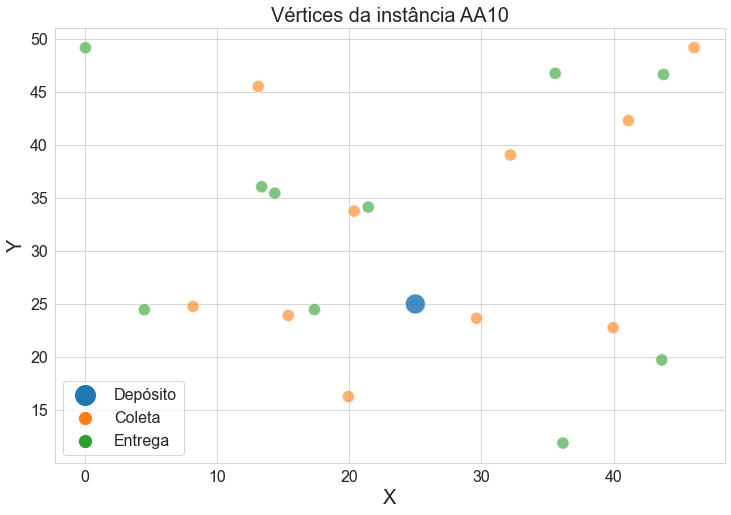

In [4]:
# Visualizando vértices da instância:

df['NODE_TYPE'] = ['Depósito'] + ['Coleta' if demand >= 0 else 'Entrega' for demand in df['DEMAND'] if demand != 0] + ['Depósito']

plt.figure(figsize=(12,8))

sns.scatterplot(x=df['XCOORD'],y=df['YCOORD'], hue=df['NODE_TYPE'], size=df['NODE_TYPE'], sizes=[400,150,150], alpha=0.6)

plt.title('Vértices da instância {}'.format(instancia), fontsize=20)

plt.xlabel('X', fontsize=20)

plt.ylabel('Y', fontsize=20)

plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()


#### Variáveis de decisão:

In [5]:
# criando o modelo:

PDPTW = Model(name='PDPTW')

# variável binária x_{ij}, igual a 1 se e somente se um veículo viaja diretamente de i para j

x = PDPTW.binary_var_matrix(range(N), range(N), name='x')

# variável contínua Q_{i}, que indica a carga no veículo após visitar o nó "i"

Q = PDPTW.continuous_var_list(range(N), name='Q') # definindo o domínio como N por dificuldades na modelagem

# variável contínua B_{i}, que indica o tempo em que o veículo começa a servir o nó "i"

B = PDPTW.continuous_var_list(range(N), name='B')

# variável contínua v_{i}, que é igual ao índice do primeiro nó visitado pela rota que contém o nó "i"

v = PDPTW.continuous_var_list(pd.concat([P, D]).index, name='v')

## Modelo


#### Função objetivo

## $$ min \displaystyle \sum_{i \in N}\displaystyle \sum_{j \in N}c_{ij}x_{ij} + \displaystyle \sum_{j \in N}Cx_{0j}$$

In [6]:
# armazenando a expressão para o custo total em uma variável:

# Custo para cada veículo alocado
custo_veiculo = 10000

custo_total = PDPTW.sum(c[i,j]*x[i,j] for i in range(N) for j in range(N)) + PDPTW.sum(
                x[0,j]*custo_veiculo for j in range(N))

PDPTW.minimize(custo_total)


#### Restrições

## $ (2) $ 
## $$\displaystyle \sum_{i \in N}x_{ij} = 1, \hspace{20 mm} \forall j \in P \cup D  $$



In [7]:
for j in list(pd.concat([P,D]).index): # P U D utilizado como os índices de um dataframe concatenado novamente
    
    PDPTW.add_constraint(PDPTW.sum(x[i,j] for i in range(N-1) if (i != j)) == 1) # i diferente de j e não incluindo o último nó
    

## $ (3) $ 
## $$\displaystyle \sum_{j \in N}x_{ij} = 1, \hspace{20 mm} \forall i \in P \cup D  $$



In [8]:
for i in list(pd.concat([P,D]).index):
    
    PDPTW.add_constraint(PDPTW.sum(x[i,j] for j in range(1,N) if (j != i)) == 1 ) # j diferente de i e a partir de 1
    

## $ (4) $ 
## $$ B_{j} \geq B_{i} + (t_{ij}+d_{i})x_{ij} - M(1-x_{ij}), \hspace{20 mm} \forall i \in N; j \in N   $$



In [9]:
for i in range(N):
    
    for j in range(N):
            
        M = l[i] - e[j]

        PDPTW.add_constraint(B[j] >= B[i] + (t[i,j] + d[i])*x[i,j] - (1-x[i,j])*(M))
        

## $ (5) $ 
## $$ Q_{j} \geq Q_{i} + q_{j}x_{ij} - M(1-x_{ij}), \hspace{20 mm} \forall i \in N; j \in N   $$



In [10]:
for i in range(N):
    
    for j in range(N):
        
        M = Cap + q[i]
  
        PDPTW.add_constraint(Q[j] >= Q[i] + q[j]*x[i,j] - M*(1-x[i,j]))
        

## $ (6) $ 
## $$ e_{i} \leq B_{i} \leq l_{i} , \hspace{20 mm} \forall i \in N $$



In [11]:
for i in range(N):
    
    PDPTW.add_constraint(e[i] <= B[i])
    PDPTW.add_constraint(B[i] <= l[i])


## $ (7) $ 
## $$ max\{0, q_{i}\} \leq Q_{i} \leq min\{ Cap, Cap+q_{i}\} , \hspace{20 mm} \forall i \in N $$



In [12]:
for i in range(N):
    
    PDPTW.add_constraint(max(0, q[i]) <= Q[i])
    PDPTW.add_constraint(Q[i] <= min(Cap, Cap+q[i]))


## $ (8) $ 
## $$  B_{n+i} \geq B_{i} + t_{i,i+n} , \hspace{20 mm} \forall i \in P $$



In [13]:
for i in P.index:

    PDPTW.add_constraint(B[n+i] >= B[i] + t[i,i+n])
    

## $ (9) $ 
## $$  v_{n+i} = v_{i} , \hspace{20 mm} \forall i \in P $$



In [14]:
for i in P.index:
    
    PDPTW.add_constraint(v[n+i-1] == v[i-1]) # é preciso colocar "-1" porque a indexação começa em 0, e a variável não
                                             # ficaria definida para v_{1} 

## $ (10) $ 
## $$  v_{j} \geq j \cdot x_{0j} , \hspace{20 mm} \forall j \in P \cup D $$



In [15]:
for j in pd.concat([P, D]).index:
    
    PDPTW.add_constraint(v[j-1] >= j*x[0,j]) # é necessário o "-1" pelo mesmo motivo anterior
    

## $ (11) $ 
## $$  v_{j} \leq j \cdot x_{0j} - n(x_{0j}-1) , \hspace{20 mm} \forall j \in P \cup D $$



In [16]:
for j in pd.concat([P, D]).index:
    
    PDPTW.add_constraint(v[j-1] <= j*x[0,j]-n*(x[0,j] - 1))


## $ (12) $ 
## $$  v_{j} \geq v_{i} + n(x_{ij}-1) , \hspace{20 mm} \forall i,j \in P \cup D $$



In [17]:
for j in pd.concat([P, D]).index:
    
    for i in pd.concat([P, D]).index:
        
        PDPTW.add_constraint(v[j-1] >= v[i-1] + n*(x[i,j]-1))
        

## $ (12) $ 
## $$  v_{j} \leq v_{i} + n(1-x_{ij}) , \hspace{20 mm} \forall i,j \in P \cup D $$



In [18]:
for j in pd.concat([P, D]).index:
    
    for i in pd.concat([P, D]).index:
    
        PDPTW.add_constraint(v[j-1] <= v[i-1] + n*(1-x[i,j]))
        


#### Valid inequalities

## $$x_{ii} = 0,  x_{i0} = 0, x_{2n+2, i} = 0, \hspace{20 mm} \forall i \in N  $$

In [19]:
# importante notar que, sem as duas primeiras valid inequalities, o modelo não dá soluções adequadas

for i in range(N):
    
    PDPTW.add_constraint(x[i,i] == 0) 
    PDPTW.add_constraint(x[i,0] == 0)
    PDPTW.add_constraint(x[N-1, i] == 0)

    
# Erro no artigo -> utiliza-se "n" tanto para o número de pedidos (n) quanto para o número de nós (N ou 2n+2)
# O domínio dessas valid inequalities pode ser definido em N e não em P U D

## $$x_{0,n+i} = 0,  x_{i,2n+2} = 0, x_{i+n, i} = 0, \hspace{20 mm} \forall i \in P $$

In [20]:
for i in P.index:
    
    PDPTW.add_constraint(x[0,n+i] == 0)
    PDPTW.add_constraint(x[i, N-1] == 0)
    PDPTW.add_constraint(x[i+n, i] == 0)
    

## $$x_{0,i} = 0, \hspace{20 mm} \forall i \in D  $$

In [21]:
for i in D.index:
    
    PDPTW.add_constraint(x[0,i] == 0)


## $$x_{ij} = 0, \hspace{10 mm} \forall i \in P \cup D \hspace{3 mm} \text{ tal que} \hspace{3 mm} e_{i} + t_{ij} > l_{j} $$

In [22]:
for i in pd.concat([P, D]).index:
    
    for j in pd.concat([P, D]).index:
        
        if e[i] + t[i,j] > l[j]:
            
            PDPTW.add_constraint(x[i,j] == 0)
            

## $$x_{ij} = 0,  x_{i,j+n} = 0, x_{i+n, j+n} = 0, \hspace{10 mm} \forall i \in P \hspace{3 mm} \text{ tal que} \hspace{3 mm} q_{i} + q_{j} > Cap $$

In [23]:
for i in P.index:
    
    for j in P.index:
        
        if (q[i] + q[j] > Cap) and (i != j):
            
            PDPTW.add_constraint(x[i,j] == 0)
            PDPTW.add_constraint(x[j,i] == 0)
            PDPTW.add_constraint(x[i,j+n] == 0)
            PDPTW.add_constraint(x[j,i+n] == 0)
            PDPTW.add_constraint(x[i+n, j+n] == 0)
            PDPTW.add_constraint(x[j+n, i+n] == 0)
            

In [24]:
# Ajustar o máximo tempo de processamento (em segundos)

max_t = 60

PDPTW.parameters.timelimit = max_t

In [25]:
# Ajustar o mínimo gap para obtenção de solução
    
gap = 0.004

PDPTW.parameters.mip.tolerances.mipgap = gap

In [26]:
PDPTW.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               60
CPXPARAM_MIP_Tolerances_MIPGap                   0.0040000000000000001
Tried aggregator 3 times.
MIP Presolve eliminated 2334 rows and 400 columns.
MIP Presolve modified 288 coefficients.
Aggregator did 13 substitutions.
Reduced MIP has 295 rows, 135 columns, and 955 nonzeros.
Reduced MIP has 105 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (2.85 ticks)
Found incumbent of value 100568.103756 after 0.06 sec. (4.24 ticks)
Probing time = 0.00 sec. (0.27 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
MIP Presolve modified 32 coefficients.
Reduced MIP has 294 rows, 135 columns, and 953 nonzeros.
Reduced MIP has 105 binaries, 0 generals, 0 SOSs, and 

docplex.mp.solution.SolveSolution(obj=10384.6,values={x_0_9:1,x_1_11:1,x..

In [27]:
#PDPTW.clear_constraints()

In [28]:
# colocando todas as variáveis x em uma lista:

variaveis = [valor for valor in list(PDPTW.solution.as_df()['name']) if 'x' in valor] 

# obtendo listas com os arcos da rota ótima (tratando possíveis erros)

arcos = [list(map(int,variaveis[i].replace('x','').replace('_','\n').split())) for i in range(len(variaveis))]

arcos_iniciais = [arco for arco in arcos if arco[0] == 0]

lista_rotas = list()

for arco in arcos_iniciais:
    
    rota = [0]
    
    no_seguinte = arco[1]
    
    rota.append(no_seguinte)
    
    while no_seguinte != (N-1):
        
        no_seguinte = [arco[1] for arco in arcos if arco[0] == no_seguinte][0]
        
        rota.append(no_seguinte)
    
    lista_rotas.append(rota)

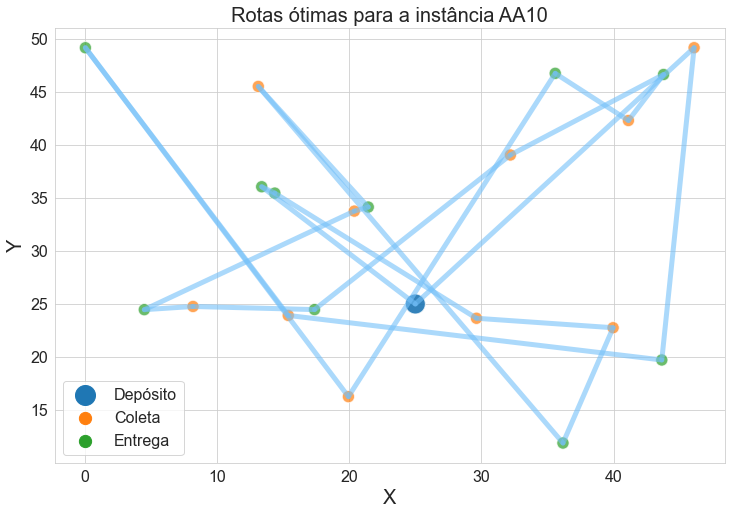

In [33]:
# Código para o plot

plt.figure(figsize=(12,8))
    
sns.scatterplot(x=df['XCOORD'],y=df['YCOORD'], hue=df['NODE_TYPE'], size=df['NODE_TYPE'], sizes=[400,150,150], alpha=0.7)

for rota in lista_rotas:
    
    cor = np.random.rand(3,)
    
    for index in range(len(rota) - 1):
        
        x_i = df['XCOORD'].iloc[rota[index]]

        x_j = df['XCOORD'].iloc[rota[index+1]]

        y_i = df['YCOORD'].iloc[rota[index]]

        y_j = df['YCOORD'].iloc[rota[index+1]]

        plt.plot((x_i,x_j),(y_i,y_j), c=cor, linewidth=5, alpha=0.6)


plt.title('Rotas ótimas para a instância {}'.format(instancia), fontsize=20)

plt.xlabel('X', fontsize=20)

plt.ylabel('Y', fontsize=20)

plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()